In [1]:
!pip install geoplot
!pip install contextily
!pip install altair

In [3]:
import pandas as pd 
import geopandas as gpd 
import nltk
nltk.download('punkt')
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import folium
import numpy as np
import seaborn as sns
import altair as alt 

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Part I : Obtention du dataframe 
## 1.1.Récupération des loyers, des surfaces et de la localisation des résidences

In [4]:
df = pd.read_csv("fr_crous_logement_france_entiere.csv", sep =';')


In [5]:
df = df[["title", "infos", "address" ,"geocalisation", "regions"]]

In [6]:
from functions_for_data_cleaning import *

df = get_loyer(df)
df = get_surface(df)
df = get_localisation(df) 
df


[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],NaN,NaN,NaN,2.044151,48.779652,POINT (2.04415 48.77965)
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],NaN,NaN,NaN,2.026887,49.048298,POINT (2.02689 49.04830)
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,"[17.0, 28.0]",28.0,17.0,22.500000,2.316971,48.790691,POINT (2.31697 48.79069)
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],18.0,18.0,18.000000,2.157896,48.698803,POINT (2.15790 48.69880)
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],NaN,NaN,NaN,2.184678,48.701542,POINT (2.18468 48.70154)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",69.0,9.0,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321)
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",35.3,19.0,27.150000,6.015343,47.236507,POINT (6.01534 47.23651)
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",51.5,18.0,35.166667,6.853714,47.638988,POINT (6.85371 47.63899)
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,NaN,NaN,NaN,5.035332,47.322498,POINT (5.03533 47.32250)


## 1.2.Récupération des loyers privés des communes (avec la géolocalisation des communes)

In [7]:
df_private = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8fac6fb7-cd07-4747-8e0b-b101c476f0da", encoding= 'unicode_escape', sep = ";")


On ne garde que le code INSEE, le nom de la ville et le loyer supérieur par m^2


In [8]:
df_private = df_private[["INSEE", "LIBGEO","upr.IPm2"]]

On renomme la colonne INSEE en codgeo pour pouvoir la merger avec la carte des contours des villes.

In [9]:
df_private.rename(columns = {'INSEE':'codgeo',"upr.IPm2" : "Loyer_prive_m2" }, inplace = True)

In [10]:
"""
On rajoute un 0 devant le code INSEE quand il ne fait que quatre chiffres (pour uniformiser avec l'autre base).
"""
df_private["codgeo"] = df_private["codgeo"].apply(lambda x : "0" + x if len(x) == 4 else x)


In [11]:
df_private = df_private.set_index('codgeo') #on réindex le dataframe avec le code INSEE pour merger après. 

On récuppère les contours géographique des communes.(prends du temps)

In [12]:
gdf_communes_boundaries = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/e9391593-fa95-4153-aabe-87ca84d197e9")

On ne garde que le code INSEE et les données polygoniales. 

In [13]:
gdf_communes_boundaries.rename(columns = {'INSEE_COM':'codgeo'}, inplace = True)
gdf_communes_boundaries = gdf_communes_boundaries[["codgeo", "geometry"]]
gdf_communes_boundaries = gdf_communes_boundaries.set_index('codgeo')


On concatène les deux datafarmes

In [14]:
gdf_private = pd.concat([df_private,gdf_communes_boundaries], axis = 1, join = "inner")

## 1.3. Jointures spatiales

In [15]:

#gdf_private['geometry'] = gdf_private['geometry'].apply(wkt.loads) #on transforme en format wkt (sinon ça ne marche pas)
gdf_private = gpd.GeoDataFrame(gdf_private)  #on transforme en geodataframe 
df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within 
#i.e si le point est dans le polynôme. 

/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_529/2580680376.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within


In [16]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure


## 1.4 Ajout des départements 

In [17]:
gdf_dep = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/eb36371a-761d-44a8-93ec-3d728bec17ce")
gdf_dep.rename(columns = {'nom':'departement'}, inplace = True)
gdf_dep = gdf_dep[["departement", "geometry"]]
gdf_dep

,departement,geometry
0,La Réunion,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,Aude,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,Haute-Loire,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,Bouches-du-Rhône,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,Lot-et-Garonne,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."
...,...,...
97,Morbihan,"MULTIPOLYGON (((-3.73508 48.11140, -3.73507 48..."
98,Doubs,"POLYGON ((5.69876 47.26464, 5.69877 47.26481, ..."
99,Jura,"MULTIPOLYGON (((5.25202 46.94451, 5.25208 46.9..."
100,Ardèche,"POLYGON ((3.86110 44.71118, 3.86110 44.71151, ..."


In [18]:
df = gpd.sjoin(df, gdf_dep, how='left', op='within')


/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_529/3352756710.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_dep, how='left', op='within')


In [19]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure

## 1.5. Association de résidences à une école 

In [20]:
df.crs = "epsg:4326" #on définit la projection de notre dataframe

In [21]:
"""
Import de notre base de données des écoles 
"""
df_schools = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0c713161-26fb-415e-ac1d-8769125f338d", sep = ";")

In [22]:
df_schools

,attention,annee_universitaire,etablissement_type,etablissement_typologie,etablissement_id_paysage,etablissement_lib,etablissement_id_wikidata,etablissement_id_ror,etablissement_id_uai,etablissement_localisation,...,etablissement_id_departement,etablissement_departement,etablissement_id_uucr,etablissement_uucr,etablissement_code_commune,etablissement_commune,etablissement_id_paysage_actuel,etablissement_actuel_lib,rentree,annee
0,Sans double compte des établissements-composan...,2006-07,Université,Université pluridisciplinaire avec santé,06SE7,Université de Bretagne Occidentale,Q1857334,01b8h3982,0290346U,Bretagne>Rennes>Finistère>Brest,...,D029,Finistère,UU29701,Brest,29019,Brest,06SE7,Université de Bretagne Occidentale,2006,2007
1,Sans double compte des établissements-composan...,2006-07,Université,Université tertiaire - droit et économie,542Id,Université Toulouse Capitole,Q590201,0443n9e75,0311382J,Occitanie>Toulouse>Haute-Garonne>Toulouse,...,D031,Haute-Garonne,UU00758,Toulouse,31555,Toulouse,542Id,Université Toulouse Capitole,2006,2007
2,Sans double compte des établissements-composan...,2006-07,Autre établissement,NaN,5y7lF,Institut universitaire de formation des maître...,NaN,NaN,9730224F,Guyane>Cayenne,...,D973,Guyane,UU9C601,Cayenne,97302,Cayenne,hy4EW,Université de Guyane,2006,2007
3,Sans double compte des établissements-composan...,2006-07,Université,Université pluridisciplinaire avec santé,7hB8r,Université de Nantes,Q259388,03gnr7b55,0440984F,Pays de la Loire>Nantes>Loire-Atlantique>Nantes,...,D044,Loire-Atlantique,UU44701,Nantes,44109,Nantes,qUCQp,Nantes Université,2006,2007
4,Sans double compte des établissements-composan...,2006-07,École,NaN,8618D,École normale supérieure PSL,Q83259,05a0dhs15,0753455Y,Île-de-France>Paris>Paris 5e,...,D075,Paris,UU00851,Paris,75105,Paris 5e,8618D,École normale supérieure PSL,2006,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,Sans double compte des établissements-composan...,2021-22,École,NaN,tdEpy,École nationale supérieure de l'électronique e...,Q2707341,03qeacd72,0951376E,Île-de-France>Versailles>Val-d'Oise>Paris>Cergy,...,D095,Val-d'Oise,UU00851,Paris,95127,Cergy,tdEpy,École nationale supérieure de l'électronique e...,2021,2022
2284,Sans double compte des établissements-composan...,2021-22,Université,Université pluridisciplinaire avec santé,vb71K,Université Paris-Est Créteil,Q980688,05ggc9x40,0941111X,Île-de-France>Créteil>Val-de-Marne>Paris>Créteil,...,D094,Val-de-Marne,UU00851,Paris,94028,Créteil,vb71K,Université Paris-Est Créteil,2021,2022
2285,Sans double compte des établissements-composan...,2021-22,Université,Université pluridisciplinaire avec santé,xJdyB,Aix-Marseille Université,Q2302586,035xkbk20,0134009M,Provence-Alpes-Côte d'Azur>Aix-Marseille>Bouch...,...,D013,Bouches-du-Rhône,UU00759,Marseille-Aix-en-Provence,13207,Marseille 7e,xJdyB,Aix-Marseille Université,2021,2022
2286,Sans double compte des établissements-composan...,2021-22,École,NaN,zHvr4,École nationale supérieure des arts et techniq...,Q3578242,NaN,0693735K,Auvergne-Rhône-Alpes>Lyon>Rhône>Lyon>Lyon 5e,...,D069,Rhône,UU00760,Lyon,69385,Lyon 5e,zHvr4,École nationale supérieure des arts et techniq...,2021,2022


In [23]:
df_schools = df_schools[df_schools["annee_universitaire"] == "2021-22" ] #on ne prend que l'année 2021-22
#df_schools = df_schools[["etablissement_lib", "effectif_sans_cpge", "etablissement_code_commune", "etablissement_commune"]]


In [24]:
df_schools.rename(columns = {'etablissement_code_commune':'codgeo'}, inplace = True) #On renomme la colonne pour la jointure


/tmp/ipykernel_529/3664660002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_schools.rename(columns = {'etablissement_code_commune':'codgeo'}, inplace = True) #On renomme la colonne pour la jointure


In [25]:
index_with_nan = df_schools.index[df_schools.isnull().any(axis=1)]
df_schools.drop(index_with_nan,0, inplace=True) 
#on enlève les valeurs manquantes (il manque des coordonnées pour certains établissments)
df_schools.set_index('codgeo', inplace = True)

/tmp/ipykernel_529/1920009635.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_schools.drop(index_with_nan,0, inplace=True)
/tmp/ipykernel_529/1920009635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_schools.drop(index_with_nan,0, inplace=True)


In [26]:
df_schools = df_schools.join(gdf_communes_boundaries)
df_schools = gpd.GeoDataFrame(df_schools)
df_schools.crs = "epsg:4326"

In [27]:
df = get_nb_student(df, df_schools, 20)

## 1.6 Dataframe finale 

In [ ]:
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,...,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,Loyer_prive_m2,departement,Schools,Nbstudents
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],...,NaN,NaN,2.044151,48.779652,POINT (2.04415 48.77965),Guyancourt,"21,73842264",Yvelines,[],0
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],...,NaN,NaN,2.026887,49.048298,POINT (2.02689 49.04830),Cergy,"20,65371054",Val-d'Oise,[],0
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,"[17.0, 28.0]",...,17.0,22.500000,2.316971,48.790691,POINT (2.31697 48.79069),Bagneux,"24,98281618",Hauts-de-Seine,[],0
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],...,18.0,18.000000,2.157896,48.698803,POINT (2.15790 48.69880),Bures-sur-Yvette,"21,2713506",Essonne,[],0
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],...,NaN,NaN,2.184678,48.701542,POINT (2.18468 48.70154),Orsay,"21,07028697",Essonne,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",...,9.0,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321),Hérouville-Saint-Clair,"13,70540711",Calvados,[],0
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",...,19.0,27.150000,6.015343,47.236507,POINT (6.01534 47.23651),Besançon,"13,92609502",Doubs,[],0
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",...,18.0,35.166667,6.853714,47.638988,POINT (6.85371 47.63899),Belfort,"13,04684054",Territoire-de-Belfort,[],0
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,...,NaN,NaN,5.035332,47.322498,POINT (5.03533 47.32250),Dijon,"14,38634283",Côte-d'Or,[],0


# II. Visualisation 

## 2.1 Création des variables d'intérêt 

#### Dans cette première partie, nous créons tout d'abord nos variables d'intérêt sur lesquelles vont porter nos graphiques. 
#### Nous nous intéressons aux disparités de loyers et de surfaces des logements proposés par les résidences Crous entre département. Nous nous intéressons également aux inégalités en termes de pression de la demande étudiante de logement Crous entre les différents départements français. 

##### Pour cela, nous créons les variables de prix par m2 du loyer des studios (prix_par_m2_surf_min) et des studios/colocations (prix_par_m2_surf_max) au sein des logements Crous que nous pourrons alors comparer avec le prix par m2 des loyers proposés dans le privé

In [29]:
df['prix_par_m2_surf_min'] = df['Min Loyer']/df['Min Surface']

In [30]:
df['prix_par_m2_surf_max'] = df['Max Loyer']/df['Max Surface'] 

In [31]:
df["Loyer_prive_m2"] = df["Loyer_prive_m2"].apply(lambda x : x.replace(',', '.'))

In [32]:
df["Loyer_prive_m2"] = df["Loyer_prive_m2"].astype(float)

##### Nous créons également dans un nouveau dataframe, un indicateur du nombre d'étudiants par département sur le nombre de résidences Crous disponibles pour représenter la pression étudiante de la demande de logement Crous.

In [33]:
Nb_residence_par_dep = df.reset_index().groupby('departement')['index'].nunique()
Nb_residence_par_dep = pd.DataFrame(Nb_residence_par_dep)
nb_eleve_dep = df_schools.groupby('etablissement_departement').sum()['effectif_sans_cpge']
nb_eleve_dep = pd.DataFrame(nb_eleve_dep)
nb_residence_par_eleves = Nb_residence_par_dep.join(nb_eleve_dep, how = 'inner')
nb_residence_par_eleves = nb_residence_par_eleves.assign(Nb_by_students=lambda x: x["effectif_sans_cpge"]/x["index"])
nb_residence_par_eleves = nb_residence_par_eleves.join(gdf_dep.set_index("departement"))
nb_residence_par_eleves = gpd.GeoDataFrame(nb_residence_par_eleves)
nb_residence_par_eleves.reset_index(inplace = True)
nb_residence_par_eleves

/tmp/ipykernel_529/1301319100.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nb_eleve_dep = df_schools.groupby('etablissement_departement').sum()['effectif_sans_cpge']


,etablissement_departement,index,effectif_sans_cpge,Nb_by_students,geometry


##### Pour étudier la répartion des résidences Crous en Fance, nous créons par ailleurs un dataframe représentant les départements avec le plus de résidences Crous

In [ ]:
df_nb_res_plus = df_nb_res.loc[(df_nb_res['comptage_résidence']>20)] 
departments = df_nb_res_plus['departement']
Nb_résidence = df_nb_res_plus['comptage_résidence']

##### Enfin, lorsque le nombre de valeurs manquantes (surfaces ou loyers) est trop important, nous créons une variable de ratio pour corriger ce biais potentiel de représentation. 

##### ratio sur le prix au m2 des studios Crous

In [ ]:
df_ratio_min = df
df_ratio_min['prix_par_m2_surf_min_null'] = df.prix_par_m2_surf_min.isnull()
df_ratio_min['prix_par_m2_surf_min_null'] = df.groupby(['departement'], as_index=False)['prix_par_m2_surf_min_null'].transform('sum').astype(int)
df_ratio_min['comptage_résidence'] = df.groupby(['departement'])['compteur'].transform('sum').astype(int) 
df_ratio_min = df_ratio_min.drop(df_ratio_min[df_ratio_min['prix_par_m2_surf_min_null']/df_ratio_min['comptage_résidence']> 0.5)
       

##### ratio sur le prix au m2 des studio/colocation 

In [ ]:
df_ratio_max = df
df_ratio_max['prix_par_m2_surf_max_null'] = df.prix_par_m2_surf_min.isnull()
df_ratio_max['prix_par_m2_surf_max_null'] = df.groupby(['departement'], as_index=False)['prix_par_m2_surf_max_null'].transform('sum').astype(int)
df_ratio_max['comptage_résidence'] = df.groupby(['departement'])['compteur'].transform('sum').astype(int) 
df_ratio_max = df_ratio_max.drop(df_ratio_max[df_ratio_max['prix_par_m2_surf_max_null']/df_ratio['comptage_résidence']> 0.5)       

##### Je fais une jointure pour n'avoir que les départements qui remplissent les deux conditions précedentes. 

In [ ]:
df_departement_ratio = pd.merge(df_ratio_max, df_ratio_min, left_on='departement', right_on='departement', how='inner')

## 2.2 Statistiques générales des logements en résidence Crous en France   

##### On remarque que la location en prix au m2 en colocation est en générale plus faible que celle en studio, c'est un résultat plutôt cohérent auquel on pouvait s'attendre. D'autre part, l'écart-type sur les loyers en studio est assez élevé, ce qui implique une certaine disparité de prix entre les résidences Crous à l'échelle nationale. 

In [34]:
df_stats = df[['Min Loyer', 'Max Loyer', 'Min Surface', 'Max Surface', 'prix_par_m2_surf_min', 'prix_par_m2_surf_max']]
df_stats.describe()

,Min Loyer,Max Loyer,Min Surface,Max Surface,prix_par_m2_surf_min,prix_par_m2_surf_max
count,481.000000,481.000000,504.000000,504.000000,376.000000,376.000000
mean,315.831705,416.287173,17.398373,28.274663,20.145139,17.254276
std,74.979906,112.564993,6.642630,15.237555,5.823618,6.163041
min,146.000000,146.000000,9.000000,9.000000,3.522727,3.522727
25%,258.000000,350.000000,15.000000,18.000000,16.661433,13.170366
50%,317.590000,403.000000,18.000000,25.000000,19.549706,17.543889
75%,362.000000,467.000000,19.000000,33.000000,23.268529,20.359944
max,635.000000,823.000000,88.000000,99.000000,68.777778,53.826087


## 2.3   Est-ce que toutes les résidences Crous se ressemblent ? 

### 2.3.1  Représentation des différentes surfaces des logements proposés par les résidences Crous en fonction du département 

Text(0.5, 1.0, 'Répartition des surfaces des logements dans les résidences Crous')

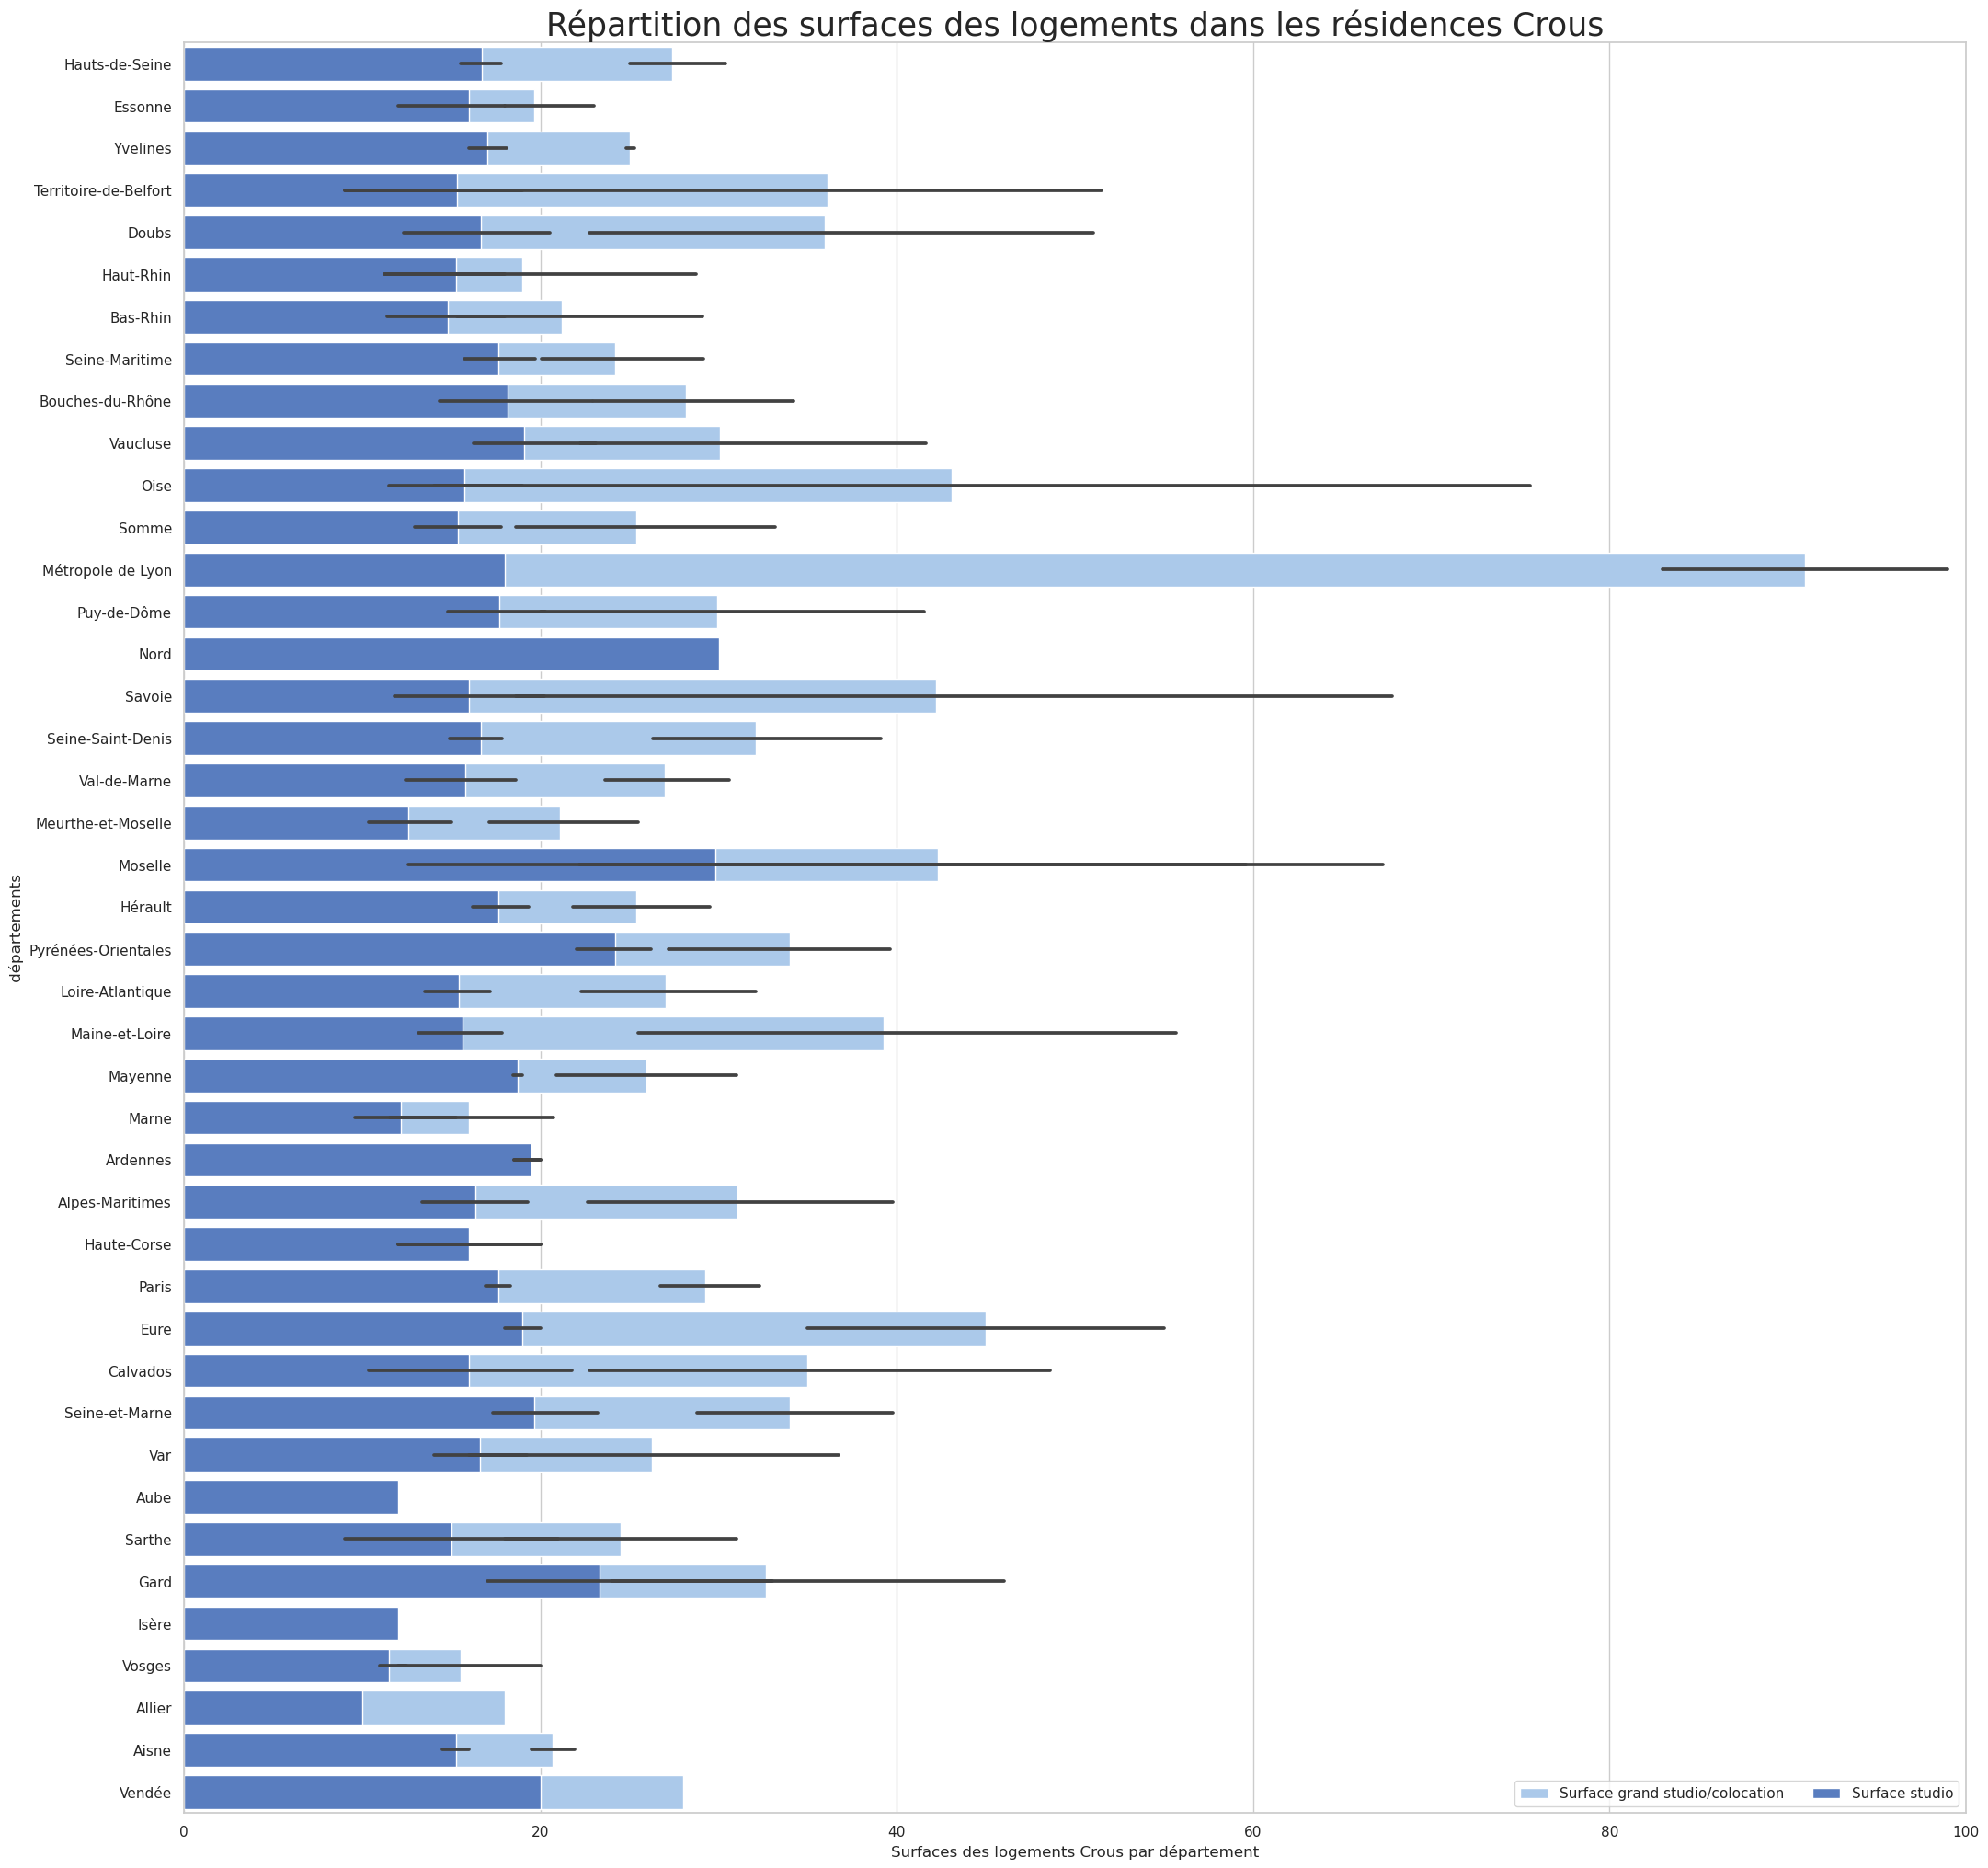

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Load the example car crash dataset
surfaces = df.dropna()

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(y="departement", x="Max Surface", data=surfaces,
            label="Surface grand studio/colocation", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(y="departement", x="Min Surface", data=surfaces,
            label="Surface studio", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 100), ylabel=" départements ",
       xlabel="Surfaces des logements Crous par département")
plt.title("Répartition des surfaces des logements dans les résidences Crous", size = 25) 
#sns.despine(left=True, bottom=True)

### 2.3.2 Disparité du prix du loyer au m2 entre les résidences Crous par département et comparaison avec le privé

##### Pour comparer le prix des loyers au sein des différents Crous, nous avons choisi d'utiliser un indicateur de prix au m2 pour prendre en considération les disparités de surfaces des logements Crous entre département comme le montre le graphique précédent.  

##### Dans le graphique ci-dessous, nous comparons le prix par département des logements studios (prix_par_m2_surf_min) et studio/colocation en résidence Crous (prix_par_m2_surf_max) avec le prix au m2 des loyers dans le privé dans les mêmes départements.

/tmp/ipykernel_529/508078580.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ordered_df = df.dropna().groupby("departement").mean().sort_values(by='prix_par_m2_surf_max')


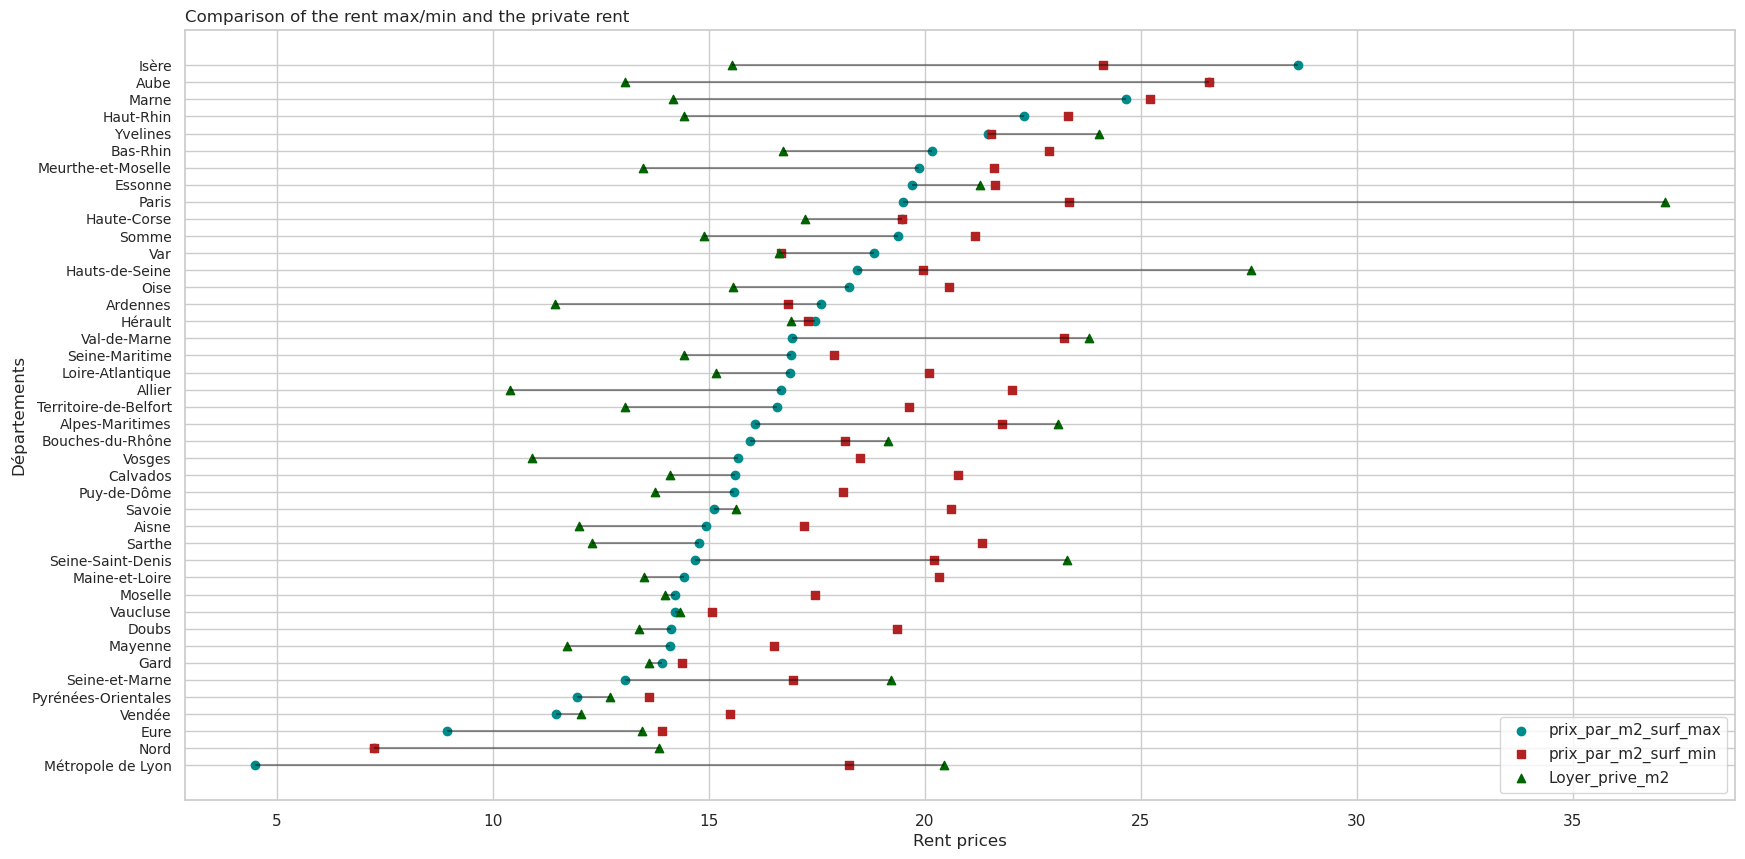

In [37]:
fig, ax = plt.subplots(figsize=(20, 10))
# Reorder it following the values of the first value:

ordered_df = df.dropna().groupby("departement").mean().sort_values(by='prix_par_m2_surf_max')
my_range=ordered_df.index
 
# The horizontal plot is made using the hline function
plt.hlines(y= my_range, xmin=ordered_df['prix_par_m2_surf_max'], xmax=ordered_df['Loyer_prive_m2'], color='black', alpha=0.4)
plt.scatter(ordered_df['prix_par_m2_surf_max'], my_range, color='darkcyan', alpha=1, marker = 'o', label='prix_par_m2_surf_max')
plt.scatter(ordered_df['prix_par_m2_surf_min'], my_range, color='firebrick', alpha=1,  marker = 's', label='prix_par_m2_surf_min')
plt.scatter(ordered_df['Loyer_prive_m2'], my_range, color='darkgreen', alpha=1 ,marker = '^', label='Loyer_prive_m2')
plt.legend()

    
# Add title and axis names
plt.yticks(my_range, ordered_df.index, fontsize= 10)
plt.title("Comparison of the rent max/min and the private rent", loc='left')
plt.xlabel('Rent prices')
plt.ylabel('Départements')
ax.legend(loc = 4, bbox_to_anchor = (1,0))
plt.style.use("ggplot")


# Show the graph
plt.show()

##### Nous remarquons que pour la Métropole de Lyon, on obtient un prix au m2 pour une colocation très faible par rapport aux autres données. Après vérification, il s'avère que parmi les 32 résidences Crous présentes dans la métropole lyonnaise, seules deux résidences ont renseigné la surface des logements disponibles. De ce fait, pour la Métropole de lyon, le résultat obtenu est assez biaisé car nous n'avons pas pu calculer le prix au m2 des loyers pour les 30 résidences restantes. Pour corriger ce biais, nous créons une variables de ratio qui permet de ne retenir que les départements où nous avons pu extraire des données pour une majorité des résidences présentes dans ce département. 

### 2.3.3 Disparité du prix du loyer au m2 entre les résidences Crous de France et comparaison avec le privé en se restreignant aux départements où nous avons des données pour au moins la moitié des résidences Crous présentes au sein du département.

##### On utilise pour cela la dataframe df_departement_ratio créée à cet effet 

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
# Reorder it following the values of the first value:

ordered_df = df_departement_ratio .dropna().groupby("departement").mean().sort_values(by='prix_par_m2_surf_max')
my_range=ordered_df.index
 
# The horizontal plot is made using the hline function
plt.hlines(y= my_range, xmin=ordered_df['prix_par_m2_surf_max'], xmax=ordered_df['Loyer_prive_m2'], color='black', alpha=0.4)
plt.scatter(ordered_df['prix_par_m2_surf_max'], my_range, color='darkcyan', alpha=1, marker = 'o', label='prix_par_m2_surf_max')
plt.scatter(ordered_df['prix_par_m2_surf_min'], my_range, color='firebrick', alpha=1,  marker = 's', label='prix_par_m2_surf_min')
plt.scatter(ordered_df['Loyer_prive_m2'], my_range, color='darkgreen', alpha=1 ,marker = '^', label='Loyer_prive_m2')
plt.legend()

    
# Add title and axis names
plt.yticks(my_range, ordered_df.index, fontsize= 10)
plt.title("Comparison of the rent max/min and the private rent within departements that contain enough values", loc='left')
plt.xlabel('Rent prices')
plt.ylabel('Départements')
ax.legend(loc = 4, bbox_to_anchor = (1,0))
plt.style.use("ggplot")


# Show the graph

## 2.4 Répartition des étudiants dans l'enseignement supérieur en France 

### 2.4.1 Nombre d'étudiants de l'enseignement supérieur en France par département

##### On utilise le dataframe nb_eleve_dep créé à cet effet 

In [2]:
fig, ax = plt.subplots(figsize=(30, 10)) 
plt.bar(nb_eleve_dep.index,nb_eleve_dep )
plt.xticks(departments, rotation = 'vertical', size =7)
plt.title("Nombre d'étudiants de l'enseignement supérieur en France par département", loc='left')
plt.xlabel('Départments') 
plt.ylabel("Nombre d'étudiants par département")
plt.style.use("ggplot") 
plt.show()

NameError: name 'plt' is not defined

## 2.5 Comment les résidences Crous s'adaptent-elles au nombre d'étudiants par département ? 

### 2.5.1 Classement des départements avec le plus de résidences Crous 

##### Nous utilisons pour cela, les variables : departments = df_nb_res_plus['departement'] et Nb_résidencedf_nb_res_plus['comptage_résidence'] créées à cet effet.

##### On devrait observer que les départements avec le plus de résidences Crous sont aussi ceux avec le plus d'étudiants présents

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10)) 
plt.bar(departments,Nb_résidence )
plt.xticks(departments, rotation = 'vertical', size =7)
plt.title("Départements avec le plus de résidences résidences Crous (>20)", loc='left')
plt.xlabel('Départments') 
plt.ylabel('Nombre de résidence Crous')
plt.style.use("ggplot")  
plt.show()

#### Néanmoins, est-ce suffisant ? Comme nous le montre la carte ci-après, la pression de demande de logement Crous est toujours élevé dans de nombreux département français. 

### 2.5.2 Représentation graphique de la pression de la demande de logement Crous (indicateur du nombre de résidence Crous sur le nombre d'élève par département) 

In [ ]:

"""
On récupère un fond de carte de la France.
"""

France = gpd.read_file("https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/france.geojson")


/opt/mamba/lib/python3.10/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/mamba/lib/python3.10/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 1
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/opt/mamba/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/mamba/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/mamba/lib/python3.10/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


KeyError: 'level_0'

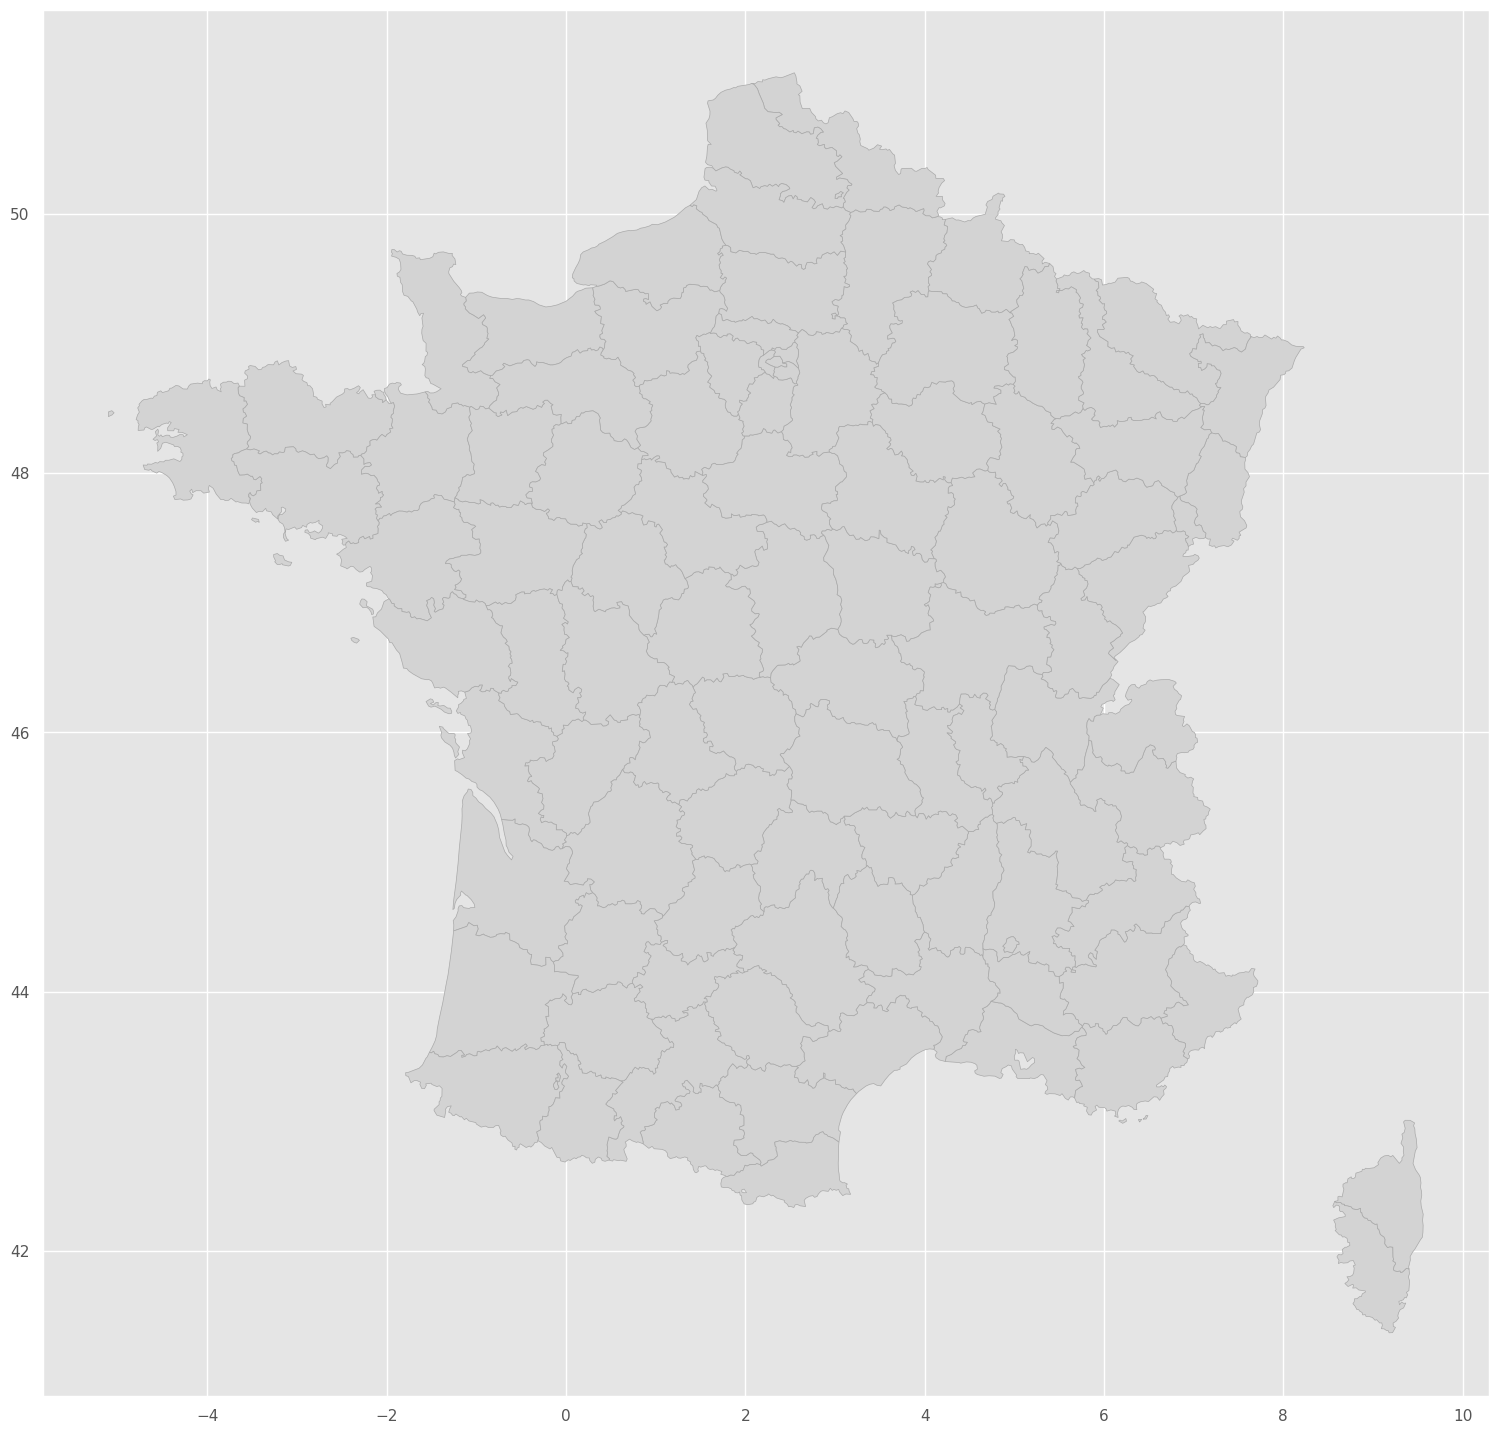

In [41]:

"""
Carte nb étudiants/nb crous par départment
"""

fig, ax = plt.subplots(figsize=(20, 18))
France.plot(ax =ax, edgecolor='darkgrey', facecolor='lightgrey')

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(nb_residence_par_eleves['Nb_by_students'], k=7)

# Map
gplt.choropleth(nb_residence_par_eleves[(nb_residence_par_eleves["level_0"] != "Guyane") & (nb_residence_par_eleves["level_0"] != "La Réunion") &
                                        (nb_residence_par_eleves["level_0"] !="Martinique") & (nb_residence_par_eleves["level_0"] !="Guadeloupe")], 
    hue= "Nb_by_students" , 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
                
);
plt.legend()
plt.style.use("seaborn-notebook")
ax.legend(loc = 4)
ax.set_title('Mean crous rent in french departements', fontsize=13);



## 2.6 Est-ce que les loyers dans le privé profitent de la rareté des logements Crous ? 

##### Autrement dit, est-ce que dans les zones où le nombre nb étudiants/nb crous  est très élevé, les loyers dans le privé sont largement plus élevés que dans les logements Crous ?

##### Pour cela on utilise le dataframe nb_residence_par_eleves où l'on retient les 10 départements avec le ratio nb étudiants/nb crous le plus élevé et on lui applique le graphique Lollipop sur les 10 départements sélectionnés.

In [ ]:
nb_residence_par_eleves # on sélectionne les 10 départements où le ratio est le plus élevé 

## 2.2 La France des Crous

On retire les territoires et régions d'Outre-Mer pour réaliser des carte

In [ ]:
df_metro = df[ (df["regions"] != "La Réunion") &

                    (df["regions"] != "Guadeloupe") &

                    (df["regions"] != "Martinique") &

                    (df["regions"] != "Guyane")]

df_metro.reset_index(inplace = True)


### 2.2.1 Classical maps

In [ ]:

"""
On récupère un fond de carte de la France.
"""

France = gpd.read_file("https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/france.geojson")


In [ ]:
fig, ax = plt.subplots(figsize=(24, 18))
plt.style.use("default")
France.plot(ax =ax, edgecolor='darkgrey', facecolor='lightgrey')

df_metro.plot(ax = ax, color='red') 



### 2.2.2. Interactive maps

In [ ]:
map = folium.Map(location=[48.7144587, 2.2453842], tiles="OpenStreetMap", zoom_start=11)

# Create a geometry list from the GeoDataFrame

geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in df_metro.geometry] 


# Iterate through list and add a marker for each residence, color-coded by its type.

i = 0

for coordinates in geo_df_list:

    # Place the markers with the popup labels and data

    map.add_child(

        folium.Marker(

            location=coordinates,

            popup=

                 "Name: " + str(df_metro.title[i]) + "<br>"

                + "Moyenne Loyer: " + str(df_metro["Mean Loyer"][i]) + "<br>"

                + "Moyenne surface: " + str(df_metro["Mean Surface"][i]) + "<br>"

                + "Address: " + str(df_metro.address[i]) + "<br>"

                + "Coordinates: " + str(geo_df_list[i])

            ,

        

            icon=folium.Icon(color="blue"),

        )

    )

    i = i + 1

map

### 2.2.3 cartes statistiques 

In [ ]:
gdf_mean = df_metro.groupby(['departement']).mean()
gdf_mean['departement'] = gdf_mean.index
gdf_mean

In [ ]:
gpd_mean = gpd.GeoDataFrame(gdf_mean.set_index('departement').join(gdf_dep.set_index('departement')))

In [ ]:
gpd_mean_wout_nan = gpd_mean.dropna()

In [ ]:
gpd_mean_wout_nan

In [ ]:
fig, ax = plt.subplots(figsize=(20, 18))
France.plot(ax =ax, edgecolor='darkgrey', facecolor='lightgrey')

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(gpd_mean_wout_nan['prix_par_m2_max'], k=7)

# Map
gplt.choropleth(gpd_mean_wout_nan, 
    hue="prix_par_m2_mean", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
                
);
plt.style.use("seaborn-notebook")
ax.legend(loc = 4, bbox_to_anchor = (1,0))
plt.subplots_adjust()
ax.set_title('Mean crous rent in french departements', fontsize=13);



In [ ]:
df_max_bis = df_max[df_max["departement"] != "Guadeloupe"]
df_max_bis
gpd_mean = gpd.GeoDataFrame(df_max_bis.join(gdf_dep.set_index('departement')))
gpd_mean

In [ ]:
fig, ax = plt.subplots(figsize=(15, 18))
France.plot(ax =ax, edgecolor='darkgrey', facecolor='lightgrey')

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(gpd_mean['prix_par_m2_min'], k=5)

# Map
gplt.choropleth(gpd_mean, 
    hue="prix_par_m2_min", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
);

ax.set_title('Mean crous rent in french "departements" with residences', fontsize=13)
#df_metro.plot(ax = ax, color='darkgreen', alpha = 1, markersize = 5);

In [ ]:
df_metro

In [ ]:
fig, ax = plt.subplots(figsize=(15, 18))
France.plot(ax =ax, edgecolor='darkgrey', facecolor='lightgrey')

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(gpd_mean['prix_par_m2_min'], k=5)

# Map
gplt.choropleth(gpd_mean, 
    hue="prix_par_m2_min", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
);

ax.set_title('Mean crous rent in french "departements" with residences', fontsize=13)
df_metro.plot(ax = ax, color='darkgreen', alpha = 1, markersize = 5);

In [ ]:
fig, ax = plt.subplots(figsize=(15, 18))
France.plot(ax =ax, edgecolor='darkgrey', facecolor='lightgrey')
import mapclassify as mc
scheme = mc.Quantiles(gpd_mean_wout_nan['prix_par_m2_mean'], k=10)

# Map
gplt.choropleth(gpd_mean_wout_nan, 
    hue="prix_par_m2_mean", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax);

# Modélisation 

On commence par enlever les NaN du dataframe qui bloquent la regression linéaire

In [ ]:
from sklearn.linear_model import LinearRegression
import math
from sklearn.model_selection import train_test_split

In [ ]:
df.isnull().sum()
df2 = df
index_with_nan = df2.index[df2.isnull().any(axis=1)]
print(index_with_nan.shape)
df2.drop(index_with_nan,0, inplace=True)
df2[['Mean Loyer', 'Mean Surface']].isnull().sum()

In [ ]:
df2 = df2.reset_index()
df2

Régression linéaire de la moyenne des loyers sur la moyenne des surfaces

In [ ]:
df2['Mean Surface'].describe()

In [ ]:
var_explicatives = df2['Mean Surface']
YLoyer = df2['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
var_explicatives = (np.array(var_explicatives).reshape(-1,1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(var_explicatives,YLoyer,test_size=0.3,train_size=0.7)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst)

In [ ]:

plt.scatter(X_train, Y_train, color='red') # plotting the observation line
 
plt.plot(X_train, lin.predict(X_train), color='blue') # plotting the regression line
 
plt.title("Loyer moyen vs Surface moyenne (Training set)") # stating the title of the graph
 
plt.xlabel("Surface moyenne") # adding the name of x-axis
plt.ylabel("Loyer moyen") # adding the name of y-axis
plt.show() # specifies end of graph


In [ ]:
#Deuxième essai: regression linéaire du min Loyer sur min surface 

In [ ]:
df2[['Min Loyer', 'Min Surface']].isnull().sum()

In [ ]:
X_min_surface = df2['Min Surface'] #la variable explicative
Y_min_Loyer = df2['Min Loyer']
#on transforme Y et X en array que l'on reformate
Y_min_Loyer = np.array(Y_min_Loyer).reshape(-1,1)
X_min_surface = (np.array(X_min_surface).reshape(-1,1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_min_surface,Y_min_Loyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

In [ ]:
#avec la régression du min Loyer sur min Surface, on a un R² peu significatif

In [ ]:
#Regression linéaire du Loyer sur le nombre total d'étudiants

In [ ]:
df2['Nbstudents_total'].describe()

In [ ]:
X_Nbstudents = df2['Nbstudents_total'] #la variable explicative
YLoyer = df2['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
X_Nbstudents = (np.array(X_Nbstudents).reshape(-1,1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_Nbstudents,YLoyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

In [ ]:
plt.scatter(X_train, Y_train, color='red') # plotting the observation line
 
plt.plot(X_train, lin.predict(X_train), color='blue') # plotting the regression line
 
plt.title("Loyer moyen vs Surface moyenne (Training set)") # stating the title of the graph
 
plt.xlabel("Surface moyenne") # adding the name of x-axis
plt.ylabel("Loyer moyen") # adding the name of y-axis
plt.show() # specifies end of graph

In [ ]:
#Regression linéaire du Loyer sur le LOG du nombre total d'étudiants

In [ ]:
for i in range (0, (np.shape(df2['Nbstudents_total']))[0]): 
    if  df2['Nbstudents_total'][i]==0: 
        df2['Nbstudents_total'][i]=1 #cela permet de ne pas avoir de valeur 0 quand on applique le log
df2['Nbstudents_total'].describe()

len(df2[df2['Nbstudents_total']==0])

In [ ]:
X_log_Nbstudents = np.log(df2['Nbstudents_total']) #la variable explicative
YLoyer = df2['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
X_log_Nbstudents = (np.array(X_log_Nbstudents).reshape(-1,1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_log_Nbstudents,YLoyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

In [ ]:
df2.columns

In [ ]:
#régression linéaire du 